<a href="https://colab.research.google.com/github/boscodeeromeu/NN/blob/main/STUDENT_Lab_3_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3 Part 2: Batch Normalization 



------------------------------------------------------
*Neural Networks. Bachelor in Data Science and Engineering*

*Pablo M. Olmos pamartin@ing.uc3m.es*

*Aurora Cobo Aguilera acobo@tsc.uc3m.es*

------------------------------------------------------

**Student: Bosco de Enrique (100406718)**

Batch normalization was introduced in Sergey Ioffe's and Christian Szegedy's 2015 paper [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/pdf/1502.03167.pdf). The idea is that, instead of just normalizing the inputs to the network, we normalize the inputs to _layers within_ the network. 

> It's called **batch** normalization because during training, we normalize each layer's inputs by using the mean and variance of the values in the current *batch*.

We will first analyze the effect of Batch Normalization (BN) in a simple NN with dense layers. Then you will be able to incorportate BN into the CNN that you designed in the first part of Lab 3. 

Note: a big part of the following material is a personal wrap-up of [Facebook's Deep Learning Course in Udacity](https://www.udacity.com/course/deep-learning-pytorch--ud188). So all credit goes for them!!

## Batch Normalization in PyTorch<a id="implementation_1"></a>

This section of the notebook shows you one way to add batch normalization to a neural network built in PyTorch. 

The following cells import the packages we need in the notebook and load the MNIST dataset to use in our experiments.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import time

In [2]:
### Run this cell

from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the training  data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Neural network classes

The following class, `MLP`, allows us to create identical neural networks **with and without batch normalization** to compare. We are defining a simple NN with **two dense layers** for classification; this design choice was made to support the discussion related to batch normalization and not to get the best classification accuracy.

Two importants points about BN:

- We use PyTorch's [BatchNorm1d](https://pytorch.org/docs/stable/nn.html#batchnorm1d). This is the function you use to operate on linear layer outputs; you'll use [BatchNorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d) for 2D outputs like filtered images from convolutional layers. 
- We add the batch normalization layer **before** calling the activation function.


In [3]:
class MLP(nn.Module):
    def __init__(self,dimx,hidden1,hidden2,nlabels,use_batch_norm): #Nlabels will be 10 in our case
        
        super().__init__()
        
        # Keep track of whether or not this network uses batch normalization.
        self.use_batch_norm = use_batch_norm
        
        self.output1 = nn.Linear(dimx,hidden1)
        
        self.output2 = nn.Linear(hidden1,hidden2)        
        
        self.output3 = nn.Linear(hidden2,nlabels)
    
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1)
        
        if self.use_batch_norm:

            self.batch_norm1 = nn.BatchNorm1d(hidden1)
            
            self.batch_norm2 = nn.BatchNorm1d(hidden2)
            
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.output1(x)
        if self.use_batch_norm:
            x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.output2(x)
        if self.use_batch_norm:
            x = self.batch_norm2(x)        
        x = self.relu(x)
        x = self.output3(x)
        x = self.logsoftmax(x) 
        return x

> **Exercise:** 
> 
> - Create a validation set with the 20% of training set
> - Extend the class above to incorporate a training method where both training and validation losses are computed, and a method to evaluate the classification performance on a given set

**Note:** As we do with Dropout, for BN we have to call the methods `self.eval()` and `self.train()` in both validation and training. Setting a model to evaluation mode is important for models with batch normalization layers!

>* Training mode means that the batch normalization layers will use **batch** statistics to calculate the batch norm. 
* Evaluation mode, on the other hand, uses the estimated **population** mean and variance from the entire training set, which should give us increased performance on this test data!  

In [4]:
import copy

validloader = copy.deepcopy(trainloader)

n_train = trainloader.dataset.data.shape[0]
print(n_train)

trainloader.dataset.data = trainloader.dataset.data[0:round(n_train*0.8)]
trainloader.dataset.targets = trainloader.dataset.targets[0:round(n_train*0.8)]


validloader.dataset.data = validloader.dataset.data[round(n_train*0.8):]
validloader.dataset.targets = validloader.dataset.targets[round(n_train*0.8):]

60000


In [13]:
print(trainloader.dataset.data.shape[0],
  validloader.dataset.data.shape[0])
print(len(trainloader.dataset.targets),
  len(validloader.dataset.targets))


48000 12000
48000 12000


In [33]:
class MLP_extended(MLP):
    
    def __init__(self,dimx,hidden1, hidden2,nlabels,use_batch_norm,epochs=100,lr=0.001):
        
        super().__init__(dimx,hidden1, hidden2, nlabels, use_batch_norm)  
        
        self.lr = lr
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()              

        self.loss_during_training = [] 

        self.valid_loss_during_training = []

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.to(self.device)#we move the instance to the GPU
        
    def trainloop(self,trainloader, validloader):
        
        for e in range(int(self.epochs)):
            
            running_loss = 0.
            
            for images, labels in trainloader:  

                images, labels = images.to(self.device), labels.to(self.device)          
        
                self.optim.zero_grad() 

                out = self.forward(images.view(images.shape[0], -1))

                loss = self.criterion(out, labels)

                running_loss += loss.item()

                loss.backward()

                self.optim.step()
            
            
            # we compute the validation loss after each epoch
            with torch.no_grad():
              
              self.eval()#so we normalize with all the data

              running_loss_v = 0.

              for images, labels in validloader:

                images, labels = images.to(self.device), labels.to(self.device)          

                out_v = self.forward(images.view(images.shape[0], -1))

                loss_v = self.criterion(out_v, labels)

                running_loss_v += loss_v.item()

              self.valid_loss_during_training.append(running_loss_v/len(validloader))

            self.train()#back to normalizing with batch statistics

            self.loss_during_training.append(running_loss/len(trainloader))

            if(e % 1 == 0):
              
                print("Training loss after %d epochs: %f, Validation loss: %f" 
                      %(e,self.loss_during_training[-1], self.valid_loss_during_training[-1]))
                
    def evaluate(self,dataloader):
      accuracy = 0

      with torch.no_grad():

        self.eval()#so we normalize with all the data

        for images,labels in dataloader:

          images, labels = images.to(self.device), labels.to(self.device)          

          logprobs = self.forward(images.view(images.shape[0], -1)) 
        
          top_p, top_class = logprobs.topk(1, dim=1)
          equals = (top_class == labels.view(images.shape[0], 1))
          accuracy += torch.mean(equals.type(torch.FloatTensor))
      
      self.train()#back to normalizing with batch statistics

      return accuracy/len(dataloader)

### Create two different models for testing

* `net_batchnorm` uses batch normalization applied to the output of its hidden layers
* `net_no_norm` does not use batch normalization

Besides the normalization layers, everthing about these models is the same.

> **Exercise:** Train both models and compare the evolution of the train/validation loss in both cases

In [39]:
net_batchnorm = MLP_extended(28*28, 128, 64, 10, True, 10, 0.001)
net_no_norm = MLP_extended(28*28, 128, 64, 10, False, 10, 0.001)

In [40]:
net_batchnorm.trainloop(trainloader, validloader)
net_no_norm.trainloop(trainloader, validloader)

Training loss after 0 epochs: 0.283862, Validation loss: 0.117353
Training loss after 1 epochs: 0.103363, Validation loss: 0.103113
Training loss after 2 epochs: 0.072048, Validation loss: 0.088311
Training loss after 3 epochs: 0.054619, Validation loss: 0.083430
Training loss after 4 epochs: 0.045824, Validation loss: 0.083450
Training loss after 5 epochs: 0.037665, Validation loss: 0.091671
Training loss after 6 epochs: 0.031114, Validation loss: 0.095906
Training loss after 7 epochs: 0.029147, Validation loss: 0.095369
Training loss after 8 epochs: 0.025233, Validation loss: 0.081556
Training loss after 9 epochs: 0.022244, Validation loss: 0.083941
Training loss after 0 epochs: 0.431737, Validation loss: 0.244017
Training loss after 1 epochs: 0.219730, Validation loss: 0.164944
Training loss after 2 epochs: 0.155417, Validation loss: 0.182634
Training loss after 3 epochs: 0.124490, Validation loss: 0.130821
Training loss after 4 epochs: 0.105514, Validation loss: 0.122867
Training l

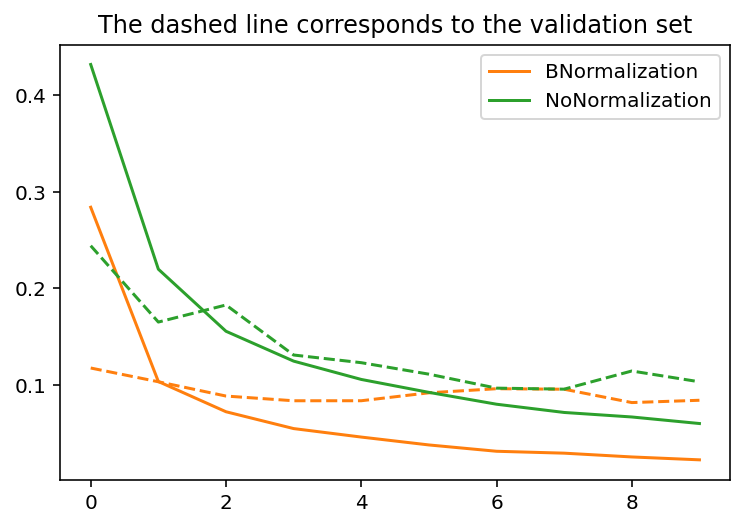

In [41]:

plt.plot(net_batchnorm.loss_during_training,label='BNormalization', color = 'C1')
plt.plot(net_batchnorm.valid_loss_during_training, '--',color = 'C1')
plt.plot(net_no_norm.loss_during_training,label='NoNormalization', color = 'C2')
plt.plot(net_no_norm.valid_loss_during_training, '--',color = 'C2')
plt.title('The dashed line corresponds to the validation set')
plt.legend()

In [42]:
train_acc_bn = net_batchnorm.evaluate(trainloader).tolist()
valid_acc_bn = net_batchnorm.evaluate(validloader).tolist()
test_acc_bn = net_batchnorm.evaluate(testloader).tolist()

train_acc_nn = net_no_norm.evaluate(trainloader).tolist()
valid_acc_nn = net_no_norm.evaluate(validloader).tolist()
test_acc_nn = net_no_norm.evaluate(testloader).tolist()

In [43]:
import pandas as pd
pd.DataFrame({'BatchNormalization': [True, False], 
             'TrainAcc':[train_acc_bn, train_acc_nn],
             'ValidAcc':[valid_acc_bn, valid_acc_nn],
             'TestAcc':[test_acc_bn, test_acc_nn]})

,BatchNormalization,TrainAcc,ValidAcc,TestAcc
0,True,0.997521,0.977061,0.978105
1,False,0.985542,0.970329,0.971935


**COMMENT**

Taking a look at the loss graph we can see one main difference in the training of both models: **the model using batch normalization converges faster than the model without batch normalization**, and as a consequence overfits faster as well (epoch 1/2 vs epoch 2/3). 
This is of course what we would expect, **batch normalization speeds up the training by reducing the internal covariate shift**, that is, by finding the distribution of layers outputs that is as stable as possible so the *optimization solution is fixed rather than dynamic (changes with iterations)* .

However there's further information we can extract from the graph. The loss curves for the batch normalized model are lower than the curves for the non-normalized model. This translates into a more precise model, which is what we see in the accuracies dataframe. 
**The reason is that while batch normalization wasn't designed to avoid overfitting, it has a positive impact on the performance**.

---
### Considerations for other network types

This notebook demonstrates batch normalization in a standard neural network with fully connected layers. You can also use batch normalization in other types of networks, but there are some special considerations.

#### ConvNets

Convolution layers consist of multiple feature maps. (Remember, the depth of a convolutional layer refers to its number of feature maps.) And the weights for each feature map are shared across all the inputs that feed into the layer. Because of these differences, batch normalizing convolutional layers requires batch/population mean and variance per feature map rather than per node in the layer.

> To apply batch normalization on the outputs of convolutional layers, we use [BatchNorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d). To use it, we simply state the **number of input feature maps**. I.e. `nn.BatchNorm2d(num_features=nmaps)`


#### RNNs

Batch normalization can work with recurrent neural networks, too, as shown in the 2016 paper [Recurrent Batch Normalization](https://arxiv.org/abs/1603.09025). It's a bit more work to implement, but basically involves calculating the means and variances per time step instead of per layer. You can find an example where someone implemented recurrent batch normalization in PyTorch, in [this GitHub repo](https://github.com/jihunchoi/recurrent-batch-normalization-pytorch).

> **Exercise:** Using CIFAR10 database, incorporate BN to your solution of Lab 3 (Part I). Compare the results with and without BN!!


First we import the CIFAR10 database

In [51]:
 transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [53]:
import copy

validloader = copy.deepcopy(trainloader)

n_train = trainloader.dataset.data.shape[0]
print(n_train)

trainloader.dataset.data = trainloader.dataset.data[0:round(n_train*0.8)]
trainloader.dataset.targets = trainloader.dataset.targets[0:round(n_train*0.8)]


validloader.dataset.data = validloader.dataset.data[round(n_train*0.8):]
validloader.dataset.targets = validloader.dataset.targets[round(n_train*0.8):]

40000


In [54]:
print(trainloader.dataset.data.shape[0],
  validloader.dataset.data.shape[0])
print(len(trainloader.dataset.targets),
  len(validloader.dataset.targets))

32000 8000
32000 8000


We apply some changes to the last class of the first part (to include batch normalization).

In [55]:
class Lenet5_drop(nn.Module):
    def __init__(self,dimx,nlabels, drop_prop = .2, drop_indx = [1,2], use_batch_norm=False):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, 
                               kernel_size=5, stride=1, padding=0)
        
        self.conv2 = nn.Conv2d(6, 16, 5, padding=0)
        
        self.pool = nn.MaxPool2d(2, 2)

        self.linear1 = nn.Linear(400, 120)
        
        self.linear2 = nn.Linear(120, 84)

        self.linear3 = nn.Linear(84, 10)
    
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1) 

        self.final_dim = int(((dimx-4)/2-4)/2)

        #dropout initialization        
        self.drop_prop = drop_prop

        self.drop_indx = drop_indx

        self.dropout = nn.Dropout(p=self.drop_prop)

        self.use_batch_norm = use_batch_norm

        if self.use_batch_norm:

            self.batch_norm_c1 = nn.BatchNorm2d(6)
            
            self.batch_norm_c2 = nn.BatchNorm2d(16)

            self.batch_norm_l1 = nn.BatchNorm1d(120)

            self.batch_norm_l2 = nn.BatchNorm1d(84)
            


    def forward(self, x):

        x = self.conv1(x)
        if self.use_batch_norm:
          x = self.batch_norm_c1(x) 
        x = self.relu(x) 
        x = self.pool(x)

        x = self.conv2(x)
        if self.use_batch_norm:
          x = self.batch_norm_c2(x) 
        x = self.relu(x)
        x = self.pool(x)

        x = x.view(len(x), self.final_dim**2*16)


        x = self.linear1(x)
        if self.use_batch_norm:
          x = self.batch_norm_l1(x) 
        x = self.relu(x)
        #dropout 1
        if 1 in self.drop_indx:
          x = self.dropout(x)


        x = self.linear2(x)
        if self.use_batch_norm:
          x = self.batch_norm_l2(x) 
        x = self.relu(x)
        #dropout 2
        if 2 in self.drop_indx:
          x = self.dropout(x)


        x = self.linear3(x)
        x = self.logsoftmax(x) 
        return x

In [56]:
class Lenet5_extended_GPU_drop(Lenet5_drop):
    
    #Your code here
    
    def __init__(self,dimx,nlabels,epochs=100,lr=0.001, drop_prop = .2, drop_indx = [1,2], use_batch_norm=False):
        
        super().__init__(dimx,nlabels, drop_prop, drop_indx, use_batch_norm)  
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()             
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 
        
        self.valid_loss_during_training = []
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.to(self.device)
        
    def trainloop(self,trainloader,validloader):
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):
            
            start_time = time.time()
            
            # Random data permutation at each epoch
            
            running_loss = 0.
            
            for images, labels in trainloader:
                
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device)  
        
                #Reset Gradients!
                self.optim.zero_grad()
            
                out = self.forward(images)

                #Your code here
                loss = self.criterion(out,labels)

                running_loss += loss.item()

                #Compute gradients
                loss.backward()
                
                #SGD stem
                self.optim.step()
                
                
            self.loss_during_training.append(running_loss/len(trainloader))
            
            # Validation Loss
            
            # Turn off gradients for validation, saves memory and computations
            with torch.no_grad():            
                
                self.eval()#drop proportion to 0

                running_loss = 0.
                
                for images,labels in validloader:
                    
                    # Move input and label tensors to the default device
                    images, labels = images.to(self.device), labels.to(self.device)               
                    
                    # Compute output for input minibatch
                    out = self.forward(images)
                    #Your code here
                    loss = self.criterion(out, labels)

                    running_loss += loss.item()   
                    
                self.valid_loss_during_training.append(running_loss/len(validloader))    
                
            self.train() #we reactivate dropout

            if(e % 1 == 0): # Every epoch

                print("Epoch %d. Training loss: %f, Validation loss: %f, Time per epoch: %f seconds" 
                      %(e,self.loss_during_training[-1],self.valid_loss_during_training[-1],
                       (time.time() - start_time)))
                
    def eval_performance(self,dataloader):
        
        loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():

            self.eval()#drop proportion to 0

            for images,labels in dataloader:
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device)
                probs = self.forward(images)

                top_p, top_class = probs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))

            self.train() #we reactivate dropout

            return accuracy/len(dataloader)

Now I will define the final model I selected in the first part (using dropout at the first dense layer with a rate of 0.5 and training with 18 epochs) using both bath normalization and no normalization whatsoever (inside the network of course).

In [73]:
my_CNN_bn = Lenet5_extended_GPU_drop(dimx=32,nlabels=10,epochs=18,lr=1e-3,
                                           drop_prop=.5, drop_indx=[1], use_batch_norm = True)
my_CNN_nn = Lenet5_extended_GPU_drop(dimx=32,nlabels=10,epochs=18,lr=1e-3,
                                           drop_prop=.5, drop_indx=[1], use_batch_norm=False)

In [74]:
my_CNN_bn.trainloop(trainloader,validloader)
my_CNN_nn.trainloop(trainloader,validloader)

Epoch 0. Training loss: 1.652794, Validation loss: 1.426206, Time per epoch: 8.280288 seconds
Epoch 1. Training loss: 1.396722, Validation loss: 1.327247, Time per epoch: 8.167698 seconds
Epoch 2. Training loss: 1.301909, Validation loss: 1.272225, Time per epoch: 7.913527 seconds
Epoch 3. Training loss: 1.243873, Validation loss: 1.183272, Time per epoch: 8.137408 seconds
Epoch 4. Training loss: 1.206717, Validation loss: 1.190130, Time per epoch: 8.164068 seconds
Epoch 5. Training loss: 1.163454, Validation loss: 1.151215, Time per epoch: 8.062436 seconds
Epoch 6. Training loss: 1.137452, Validation loss: 1.129443, Time per epoch: 7.952934 seconds
Epoch 7. Training loss: 1.113853, Validation loss: 1.106692, Time per epoch: 7.910419 seconds
Epoch 8. Training loss: 1.093068, Validation loss: 1.115164, Time per epoch: 8.209032 seconds
Epoch 9. Training loss: 1.068401, Validation loss: 1.085641, Time per epoch: 7.958485 seconds
Epoch 10. Training loss: 1.047608, Validation loss: 1.093102

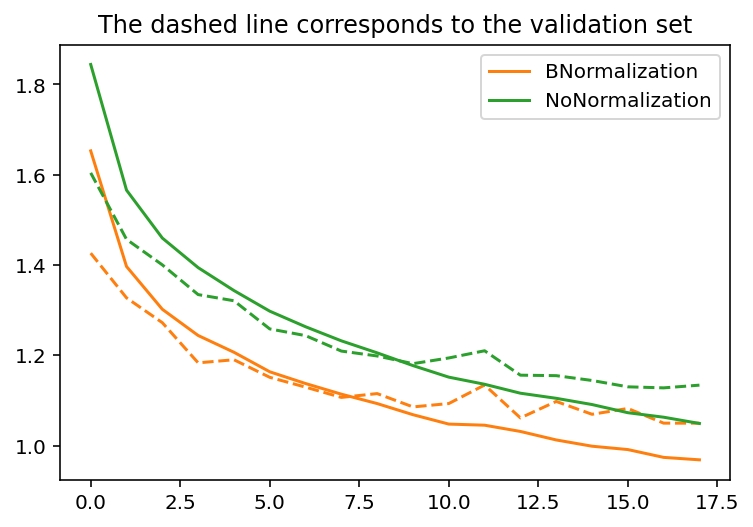

In [75]:
plt.plot(my_CNN_bn.loss_during_training,label='BNormalization', color = 'C1')
plt.plot(my_CNN_bn.valid_loss_during_training, '--',color = 'C1')
plt.plot(my_CNN_nn.loss_during_training,label='NoNormalization', color = 'C2')
plt.plot(my_CNN_nn.valid_loss_during_training, '--',color = 'C2')
plt.title('The dashed line corresponds to the validation set')
plt.legend()

In [76]:
train_acc_bn = my_CNN_bn.eval_performance(trainloader).tolist()
valid_acc_bn = my_CNN_bn.eval_performance(validloader).tolist()
test_acc_bn = my_CNN_bn.eval_performance(testloader).tolist()

train_acc_nn = my_CNN_nn.eval_performance(trainloader).tolist()
valid_acc_nn = my_CNN_nn.eval_performance(validloader).tolist()
test_acc_nn = my_CNN_nn.eval_performance(testloader).tolist()

In [78]:
import pandas as pd
pd.DataFrame({'BatchNormalization': [True, False], 
             'TrainAcc':[train_acc_bn, train_acc_nn],
             'ValidAcc':[valid_acc_bn, valid_acc_nn],
             'TestAcc':[test_acc_bn, test_acc_nn]})

,BatchNormalization,TrainAcc,ValidAcc,TestAcc
0,True,0.738125,0.629000,0.634554
1,False,0.679969,0.597875,0.603901


**COMMENT**

As with the previous MLP when we normalize we see the same characteristics; a faster training when using batch normalization and a lower loss that results in a better classification. This is again backed by the accuracies df. 
*In this case the difference in the quality of the training is larger than the case with the MLP as we see how the curves for the bn model are at every epoch below the curves for the non normalized model*.

The results using batch normalization are considerably better but not perfect as we get a better accuracy (difference of 0.01 compared to the results from lab1) but we get a larger gap between train and test accuracies (model is overfited). Therefore the following comment and code.

Furthermore, as I've already commented, models using batch normalization converge faster, and so overfit faster. Therefore, to find the best possible model and to be able to compare a batch normalized model using early stopping and a non normalized model using early stopping (the model from the previous part); i will stop the training of the bn model at epoch 6.

In [91]:
my_CNN_bn_es = Lenet5_extended_GPU_drop(dimx=32,nlabels=10,epochs=8,lr=1e-3,
                                           drop_prop=.5, drop_indx=[1], use_batch_norm = True)

In [92]:
my_CNN_bn_es.trainloop(trainloader,validloader)

Epoch 0. Training loss: 1.658142, Validation loss: 1.433627, Time per epoch: 8.026549 seconds
Epoch 1. Training loss: 1.407113, Validation loss: 1.305969, Time per epoch: 7.831532 seconds
Epoch 2. Training loss: 1.309597, Validation loss: 1.234736, Time per epoch: 8.007355 seconds
Epoch 3. Training loss: 1.247398, Validation loss: 1.178561, Time per epoch: 7.899797 seconds
Epoch 4. Training loss: 1.197677, Validation loss: 1.199817, Time per epoch: 7.842395 seconds
Epoch 5. Training loss: 1.155459, Validation loss: 1.144669, Time per epoch: 7.846503 seconds
Epoch 6. Training loss: 1.128514, Validation loss: 1.143776, Time per epoch: 7.853055 seconds
Epoch 7. Training loss: 1.103306, Validation loss: 1.121642, Time per epoch: 8.102017 seconds


No handles with labels found to put in legend.


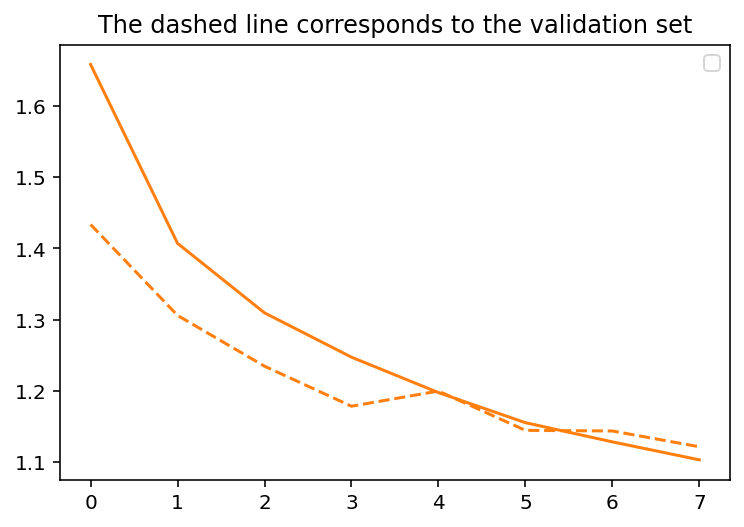

In [93]:
plt.plot(my_CNN_bn_es.loss_during_training, color = 'C1')
plt.plot(my_CNN_bn_es.valid_loss_during_training, '--',color = 'C1')
plt.title('The dashed line corresponds to the validation set')
plt.legend()

In [94]:
train_acc_bn_es = my_CNN_bn_es.eval_performance(trainloader).tolist()
valid_acc_bn_es = my_CNN_bn_es.eval_performance(validloader).tolist()
test_acc_bn_es = my_CNN_bn_es.eval_performance(testloader).tolist()

In [95]:
import pandas as pd
pd.DataFrame({'BatchNormalization': [True, False, True],
              'EarlyStopping':[False, True, True],
             'TrainAcc':[train_acc_bn, train_acc_nn, train_acc_bn_es],
             'ValidAcc':[valid_acc_bn, valid_acc_nn, valid_acc_bn_es],
             'TestAcc':[test_acc_bn, test_acc_nn, test_acc_bn_es]})

,BatchNormalization,EarlyStopping,TrainAcc,ValidAcc,TestAcc
0,True,False,0.738125,0.629000,0.634554
1,False,True,0.679969,0.597875,0.603901
2,True,True,0.665688,0.599250,0.608877


**COMMENT**

I was expecting to see an improvement with respect to the bn model without early stopping but it isn't the case. Considering that all the accuracies are below 0.7 I believe the dataset is difficult to model (at least using this approach) and so even with batch normalization we need more epochs.

In short, the model with batch normalization improves the model from lab3part1 but doesn't achieve an excellent performance. **Including early stopping after batch normalization doesn't seem to be a good idea.**